Context: https://www.kaggle.com/hellbuoy/car-price-prediction

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

pd.set_option('display.max_columns', None)

In [113]:
# reading the dataset
cars = pd.read_csv("CarPrice_Assignment.csv")
cars.sample(5)

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
180,181,-1,toyota starlet,gas,std,four,sedan,rwd,front,104.5,187.8,66.5,54.1,3131,dohc,six,171,mpfi,3.27,3.35,9.2,156,5200,20,24,15690.0
60,61,0,mazda glc custom l,gas,std,four,sedan,fwd,front,98.8,177.8,66.5,55.5,2410,ohc,four,122,2bbl,3.39,3.39,8.6,84,4800,26,32,8495.0
110,111,0,peugeot 504,diesel,turbo,four,wagon,rwd,front,114.2,198.9,68.4,58.7,3430,l,four,152,idi,3.70,3.52,21.0,95,4150,25,25,13860.0
94,95,1,nissan leaf,gas,std,two,sedan,fwd,front,94.5,165.3,63.8,54.5,1951,ohc,four,97,2bbl,3.15,3.29,9.4,69,5200,31,37,7299.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0


- How many rows/cols?

In [114]:
cars.shape

(205, 26)

- Are there any duplicates?

In [115]:
cars.duplicated().sum()

0

# Splitting

- Let's not know too much about the test & validation data by splitting the original data into 3 set (train/validation/test) before any further data exploration 

In [116]:
y_sr = cars["price"] 
X_df = cars.drop("price", axis=1)

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_sr, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)
X_train.shape, X_val.shape, X_test.shape

((147, 25), (17, 25), (41, 25))

# Data Exploration on train set

In [118]:
df_train = pd.concat([X_train, y_train], axis=1)
df_train.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
120,121,1,plymouth fury iii,gas,std,four,hatchback,fwd,front,93.7,157.3,63.8,50.6,1967,ohc,four,90,2bbl,2.97,3.23,9.4,68,5500,31,38,6229.0
119,120,1,plymouth cricket,gas,turbo,two,hatchback,fwd,front,93.7,157.3,63.8,50.8,2128,ohc,four,98,spdi,3.03,3.39,7.6,102,5500,24,30,7957.0
47,48,0,jaguar xj,gas,std,four,sedan,rwd,front,113.0,199.6,69.6,52.8,4066,dohc,six,258,mpfi,3.63,4.17,8.1,176,4750,15,19,32250.0
105,106,3,nissan kicks,gas,turbo,two,hatchback,rwd,front,91.3,170.7,67.9,49.7,3139,ohcv,six,181,mpfi,3.43,3.27,7.8,200,5200,17,23,19699.0
197,198,-1,volvo 245,gas,std,four,wagon,rwd,front,104.3,188.8,67.2,57.5,3042,ohc,four,141,mpfi,3.78,3.15,9.5,114,5400,24,28,16515.0


## Check each col's dtype

In [119]:
df_train.dtypes

car_ID                int64
symboling             int64
CarName              object
fueltype             object
aspiration           object
doornumber           object
carbody              object
drivewheel           object
enginelocation       object
wheelbase           float64
carlength           float64
carwidth            float64
carheight           float64
curbweight            int64
enginetype           object
cylindernumber       object
enginesize            int64
fuelsystem           object
boreratio           float64
stroke              float64
compressionratio    float64
horsepower            int64
peakrpm               int64
citympg               int64
highwaympg            int64
price               float64
dtype: object

Compared to **Data Dictionary - carprices.xlsx**, `symboling` should be converted to categorical col <font color='yellow'>(1)</font>

In [120]:
df_train['symboling'].astype('object')

120     1
119     1
47      0
105     3
197    -1
       ..
8       1
35      0
50      1
159     0
200    -1
Name: symboling, Length: 147, dtype: object

## Examine numeric data

In [121]:
def missing_ratio(s):
    return s.isna().sum() * 100 / len(s)

num_cols = df_train.select_dtypes([np.int64, np.float64]).columns[2:] # drop ID & symboling columns
df_train[num_cols].agg([missing_ratio, pd.Series.min, pd.Series.max, pd.Series.nunique])

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
missing_ratio,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
min,86.6,144.6,61.8,47.8,1713.0,70.0,2.54,2.07,7.0,52.0,4150.0,13.0,16.0,5195.0
max,120.9,208.1,71.7,59.8,4066.0,326.0,3.80,4.17,23.0,262.0,6600.0,49.0,54.0,40960.0
nunique,48.0,64.0,39.0,43.0,128.0,36.0,36.00,34.00,31.0,54.0,21.0,28.0,29.0,137.0


No missing data; min & max vals are quite reasonable. 

- Since linear regression assumes the linear relationship b/w independent (`price`) & dependent cols. So let's check the Pearson correlation b/w `price` & other cols. Because visualizing using pair-plot for 14 numeric features are quite hard to read, a heatmap will be used instead 
- Also, linear regression is sensitive to multicollinearity. In other words, there should be no or little multicollinearity. So let's check for that, too

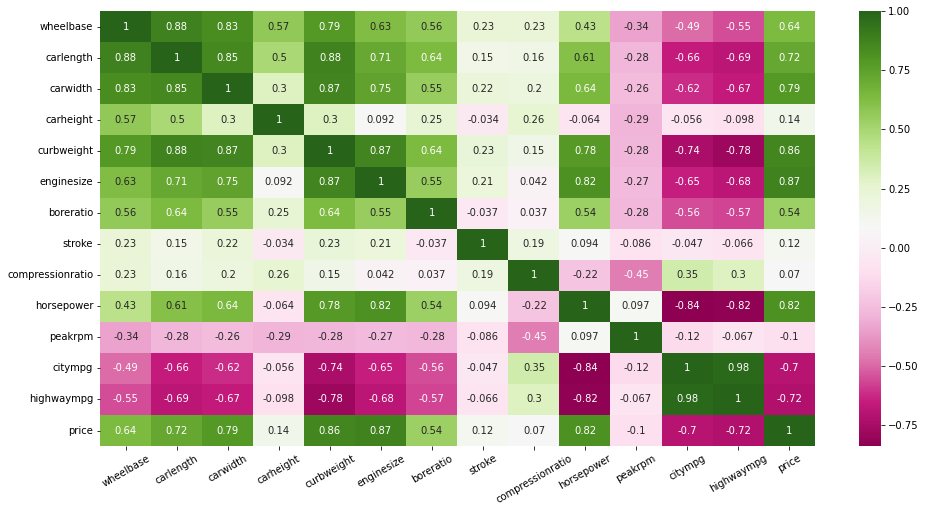

In [122]:
plt.figure(figsize=(16,8))

# cmap ref: https://python-graph-gallery.com/92-control-color-in-seaborn-heatmaps
ax = sns.heatmap(df_train[num_cols].corr(), cmap="PiYG", annot=True) 
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30);

Insights:
- `price` is highly correlated (positive & negative) with all the <font color='green'>green</font> & <font color='pink'>pink</font> cells in the last row since the corr > 0.5 (0.5 is my 'high correlation threshold'). These are the good features to keep, i.e. all the white cells should be eliminated <font color='yellow'>(2)</font>
- Multicollinearity: many independent variables are highly correlated (all 4 corners, those in green & bold pink)

Let's check each numeric column's distribution

In [124]:
len(num_cols)

14

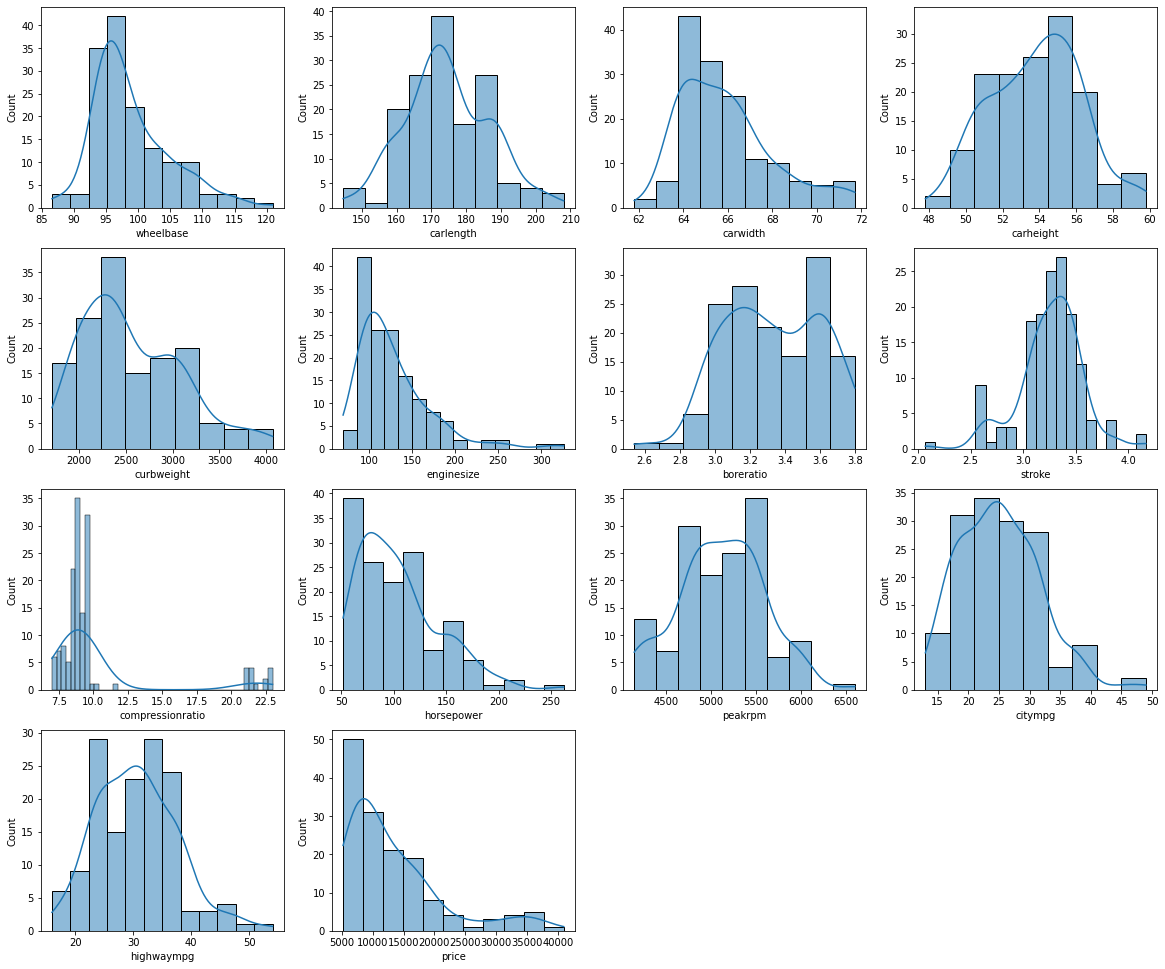

In [126]:
plt.figure(figsize=(20, 17))

for i in range(1,16):
    if i > len(num_cols):
        break
    feat = num_cols[i-1]
    plt.subplot(4, 4, i)
    sns.histplot(df_train[feat], kde=True)

## Examine categorical data

In [ ]:
cat_cols = df_train.select_dtypes([object]).columns
X_train[cat_cols].agg([missing_ratio, pd.Series.nunique, pd.Series.unique])

,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem
missing_ratio,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nunique,112,2,2,2,5,3,2,6,6,6
unique,"[plymouth fury iii, plymouth cricket, jaguar x...","[gas, diesel]","[std, turbo]","[four, two]","[hatchback, sedan, wagon, hardtop, convertible]","[fwd, rwd, 4wd]","[front, rear]","[ohc, dohc, ohcv, ohcf, l, rotor]","[four, six, two, five, twelve, eight]","[2bbl, spdi, mpfi, 1bbl, idi, 4bbl]"


- Check for balance among values of each feature

IndexError: index 9 is out of bounds for axis 0 with size 9

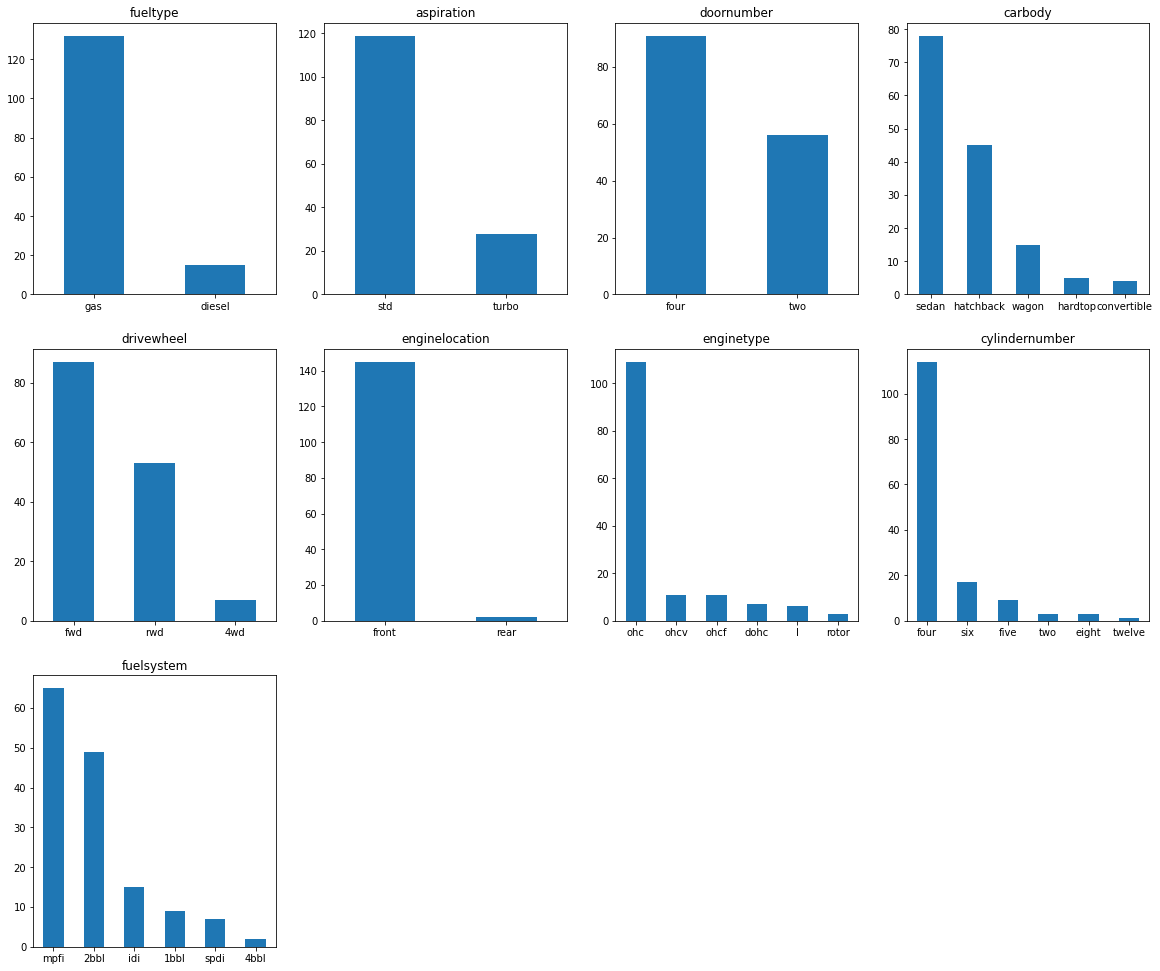

In [ ]:
plt.figure(figsize=(20, 17))
cat_col_viz = cat_cols.drop('CarName') # no need to viz this

for i in range(1,11):
    feat = cat_col_viz[i-1]
    plt.subplot(3, 4, i)
    X_train[feat].value_counts().plot.bar(rot=0, title=feat)

- Let's examine a few vals in `CarName`: A quick glance at **CarPrice_Assignment.csv** show that the company name is what occurs before a space, e.g. alfa-romero in 'alfa-romero giulia', audi in 'audi 100 ls'. It seems like there's a need for creating a new column `CompanyName` since encoding 147 values in `CarName` will result in numerous new columns $\to$ prone to overfitting <font color='yellow'>(3)</font>

In [ ]:
cars['CarName'].apply(lambda x: x.split(" ")[0])

0      alfa-romero
1      alfa-romero
2      alfa-romero
3             audi
4             audi
          ...     
200          volvo
201          volvo
202          volvo
203          volvo
204          volvo
Name: CarName, Length: 205, dtype: object

## Conclusion
This stage lists 3 main problems that need to preprocess in the next stage:
1. `symboling` should be converted to categorical col
2. Manually do feature selection by eliminate `carheight`, `stroke`, `compressionratio`, `peakrpm`
3. Add a new column `CompanyName`

# Preprocessing

Beside dealing with 3 preprocessing problems stated above in function `basic_preprocessing`, other preprocessing problems are:
- Encoding categorical values
- Scale numeric data

In [ ]:
def basic_preprocessing(X_df):
    '''this function give solutions to 3 above-mentioned problems'''
    X_out = X_df.copy()
    X_out['symboling'] = X_out['symboling'].astype('object') # (1)
    X_out['CompanyName'] = X_out['CarName'].apply(lambda x: x.split(" ")[0]) # (3)
    X_out.drop(['CarName', 'carheight', 'stroke', 'compressionratio', 'peakrpm'], axis=1, inplace=True) # (2),(3)
    return X_out

cat_transform = 

preprocess_pipeline = Pipeline([
    ('basic_preprocessing', FunctionTransformer(basic_preprocessing))
])

preprocess_pipeline.fit_transform(X_train)

,car_ID,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,horsepower,citympg,highwaympg,CompanyName
120,121,1,gas,std,four,hatchback,fwd,front,93.7,157.3,63.8,1967,ohc,four,90,2bbl,2.97,68,31,38,plymouth
119,120,1,gas,turbo,two,hatchback,fwd,front,93.7,157.3,63.8,2128,ohc,four,98,spdi,3.03,102,24,30,plymouth
47,48,0,gas,std,four,sedan,rwd,front,113.0,199.6,69.6,4066,dohc,six,258,mpfi,3.63,176,15,19,jaguar
105,106,3,gas,turbo,two,hatchback,rwd,front,91.3,170.7,67.9,3139,ohcv,six,181,mpfi,3.43,200,17,23,nissan
197,198,-1,gas,std,four,wagon,rwd,front,104.3,188.8,67.2,3042,ohc,four,141,mpfi,3.78,114,24,28,volvo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,9,1,gas,turbo,four,sedan,fwd,front,105.8,192.7,71.4,3086,ohc,five,131,mpfi,3.13,140,17,20,audi
35,36,0,gas,std,four,sedan,fwd,front,96.5,163.4,64.0,2010,ohc,four,92,1bbl,2.91,76,30,34,honda
50,51,1,gas,std,two,hatchback,fwd,front,93.1,159.1,64.2,1890,ohc,four,91,2bbl,3.03,68,30,31,maxda
159,160,0,diesel,std,four,hatchback,fwd,front,95.7,166.3,64.4,2275,ohc,four,110,idi,3.27,56,38,47,toyota
